# Camera Calibration

- chess board: http://opencv.jp/sample/pics/chesspattern_7x10.pdf

In [1]:
!rm -r calib
!mkdir -p calib

In [2]:
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
import glob

458


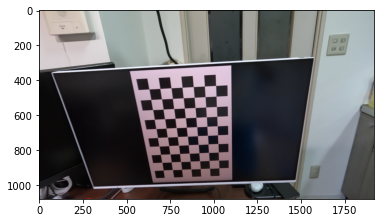

In [3]:
drop = 25
skip = 10

vid = imageio.mimread("src/calib.mp4", memtest=False)
print(len(vid))

for i, frame in enumerate(vid[drop:-drop:skip]):
    cv2.imwrite("calib/calib_{:03}.jpg".format(i), frame[..., ::-1])

plt.imshow(frame); plt.show()

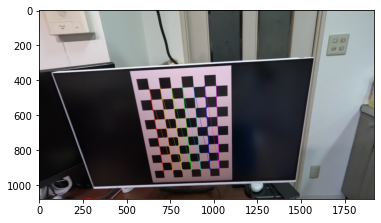

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(10-1,7-1,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

fnames = sorted(glob.glob('calib/calib_*.jpg'))

for i, fname in enumerate(fnames):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (10,7),None)

    if ret == True:
        objpoints.append(objp)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        img = cv2.drawChessboardCorners(img, (10,7), corners2,ret)

plt.imshow(img[...,::-1]); plt.show()

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

print('ret\n', ret, '\nmtx\n', mtx, '\ndist\n', dist)
np.save("camera/mtx.npy", mtx); np.save("camera/dist.npy", dist)

ret
 0.25125330727556705 
mtx
 [[1.00631525e+03 0.00000000e+00 9.56573461e+02]
 [0.00000000e+00 1.00416463e+03 5.50061327e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
dist
 [[ 0.02529833 -0.02409825  0.00238566 -0.00035251 -0.02531333]]


---

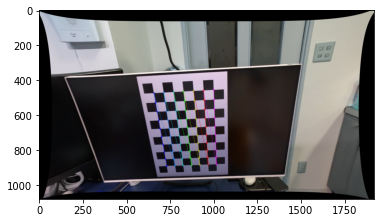

In [6]:
newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (img.shape[1], img.shape[0]), 1)
dst = cv2.undistort(img, mtx, dist, None, newmtx)

# x,y,w,h = roi; dst = dst[y:y+h, x:x+w]
plt.imshow(dst); plt.show()

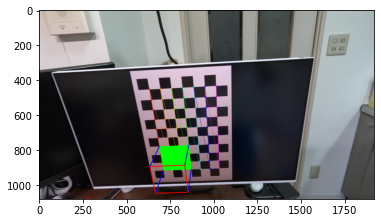

In [7]:
cube = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]])

def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0,255,0), -3)
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0,0,255), 3)
    return img

err, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)

# visualize
imgpts, jac = cv2.projectPoints(cube, rvec, tvec, mtx, dist)
img = draw(img, imgpts)

plt.imshow(img[...,::-1]); plt.show()

---

## Docs
- [Camera Calibration and 3D Reconstruction](http://opencv.jp/opencv-2.1_org/c/camera_calibration_and_3d_reconstruction.html)

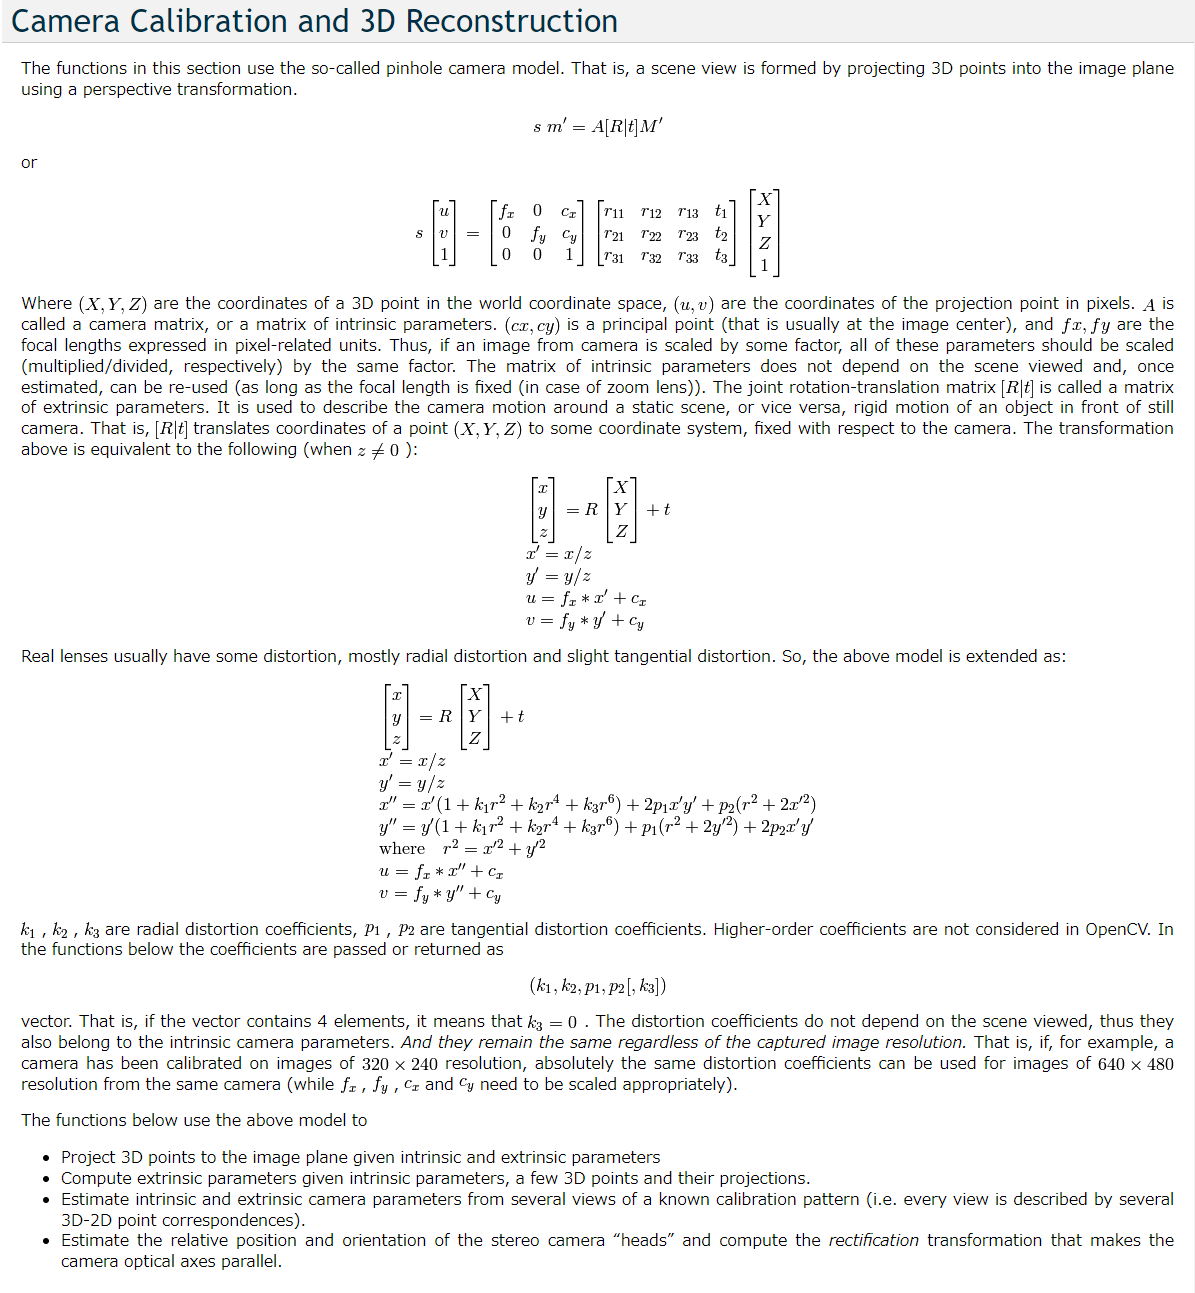

In [8]:
def world2cam(w_pos, rvec, tvec, mtx, dist):
    assert len(w_pos.shape) == 1
    w_pos = w_pos[np.newaxis, :]

    fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
    k1, k2, p1, p2 = dist[0,:4]
    R, _ = cv2.Rodrigues(rvec.squeeze())

    xyz = np.dot(R, w_pos.T) + tvec
    x, y, z = xyz[:,0]

    x_ = x / z
    y_ = y / z

    # easy ver
    # u = fx * x_ + cx
    # v = fy * y_ + cy

    r2 = x_ ** 2 + y_ ** 2
    r4 = r2 ** 2
    x__ = x_ * (1 + k1*r2 + k2*r4) + 2*p1*x_*y_ + p2*(r2 + 2*x_**2)
    y__ = y_ * (1 + k1*r2 + k2*r4) + 2*p2*x_*y_ + p1*(r2 + 2*y_**2)
    u = fx * x__ + cx
    v = fy * y__ + cy
    uv = np.array([u, v])

    # uv1 = np.dot(mtx, xyz)
    # print(uv1)

    return uv, z


def cam2world(c_pos, rvec, tvec, mtx, dist, z):
    assert len(c_pos.shape) == 1

    fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
    k1, k2, p1, p2 = dist[0,:4]
    R, _ = cv2.Rodrigues(rvec.squeeze())

    u, v = c_pos
    x_ = (u - cx) / fx
    y_ = (v - cy) / fy
    x = x_ * z
    y = y_ * z

    xyz = np.array([[x], [y], [z]])
    xyz = np.dot(R.T, xyz - tvec)  # np.dot(R.T,R) = I
    xyz = xyz.squeeze()

    return xyz


imgpoint, objpoint = corners2[-1][0], objp[-1]
uv, z = world2cam(objpoint, rvec, tvec, mtx, dist)
print("w: {} -> c: {}".format(objpoint, uv))

c_pos = corners2[0][0]
xyz = cam2world(c_pos, rvec, tvec, mtx, dist, z)
print("c: {} -> w: {}".format(c_pos, xyz))

c_pos = np.array([img.shape[1] / 2, img.shape[0] / 2])
xyz = cam2world(c_pos, rvec, tvec, mtx, dist, z)
print("c: {} -> w: {}".format(c_pos, xyz))

w: [9. 6. 0.] -> c: [1014.60454295  433.46811327]
c: [713.46344 916.537  ] -> w: [ 2.27208759  0.98201552 -2.74398811]
c: [960. 540.] -> w: [ 7.50486165  5.07564325 -0.60200791]
